# 🚗 Problem 2 — Longest Road (QUBO + QAOA / VQE)

Această problemă caută drumul cel mai lung de pe tabla Catan, formulat ca un **QUBO**.
Variabilele binare reprezintă muchiile posibile ale drumului; scopul este maximizarea lungimii și respectarea regulilor: fiecare nod are grad 0 sau 2, iar lanțurile sunt continue.

Vom rula algoritmi cuantici:
- **QAOA** (Qiskit, simulator Aer)
- **VQE** (PennyLane)

Rezultatul = configurația de muchii care maximizează lungimea drumului.

In [1]:
# --- Imports & setup ---
from pathlib import Path
import sys, os, numpy as np
import matplotlib.pyplot as plt

# adaugă 'src' în sys.path
for r in [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]:
    if (r / 'src').exists():
        sys.path.append(str(r / 'src'))
        break

from catan.utils import set_seed, print_section, cprint, Colors
from catan.board import board_for_qubits
from catan.viz import plot_board, highlight_edges
from catan.encodings.qubo import build_longest_road_qubo
from catan.encodings.qiskit_qaoa import run_qaoa_qubo, plot_energy_landscape
from catan.encodings.pennylane_vqe import run_vqe_qubo, plot_vqe_convergence, plot_vqe_probabilities

In [4]:
# --- Parameters ---
N_QUBITS = 4      # variabile (muchii)
SEED = 42
METHOD = 'qaoa'    # 'qaoa' sau 'vqe'
GAMMA_CONN = 0.25  # bonus de conectivitate locală (0..1)

set_seed(SEED)
print_section(f"Quantum Catan – P2 (Longest Road)")
cprint(f"N_QUBITS={N_QUBITS}, METHOD={METHOD}, GAMMA_CONN={GAMMA_CONN}", Colors.CYAN)


=== Quantum Catan – P2 (Longest Road) ===
N_QUBITS=4, METHOD=qaoa, GAMMA_CONN=0.25


Tiles=19, Edges=76
Selected 4 candidate edges


/home/idorando/quantum-catan-hackaton/src/catan/viz.py:157: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right")


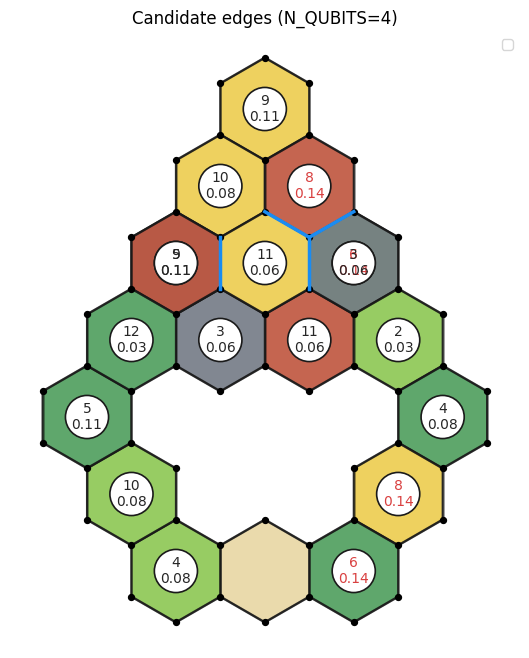

In [5]:
# --- Build board & select edges ---
board, selected_edges, var_map = board_for_qubits(n_qubits=N_QUBITS, mode='road', seed=SEED)
print(f"Tiles={board.n_tiles}, Edges={board.n_edges}")
print(f"Selected {len(selected_edges)} candidate edges")

# vizualizare muchii candidate
fig, ax = plot_board(board)
highlight_edges(board, selected_edges, ax=ax, color=(0.10, 0.55, 0.95), width=2.5, label='Candidates')
ax.set_title(f"Candidate edges (N_QUBITS={N_QUBITS})")
plt.show()

In [6]:
# --- Build QUBO for Longest Road ---
Q_model = build_longest_road_qubo(board, selected_edges, gamma_conn=GAMMA_CONN)
Q = Q_model.Q
print_section("QUBO built")
print(f"Matrix shape: {Q.shape}, nonzero ≈ {np.count_nonzero(Q)}")


=== QUBO built ===
Matrix shape: (4, 4), nonzero ≈ 10


In [7]:
# --- Run Solver ---
if METHOD.lower() == 'qaoa':
    result = run_qaoa_qubo(Q, reps=1, optimizer='COBYLA', shots=256, seed=SEED)
    bitstring = result['best_bitstring']
    energy = result['best_energy']
    cprint(f"[QAOA] Done → best={bitstring}, energy={energy:.6f}", Colors.GREEN)
else:
    result = run_vqe_qubo(Q, layers=2, steps=100, lr=0.15, optimizer='adam')
    bitstring = result['best_bitstring']
    energy = result['best_energy']
    cprint(f"[VQE] Done → best={bitstring}, energy={energy:.6f}", Colors.GREEN)

[QAOA] Done in 1.68s | Best=0101, Energy=-12.527778
[QAOA] Done → best=0101, energy=-12.527778


Chosen edges: [16, 14]


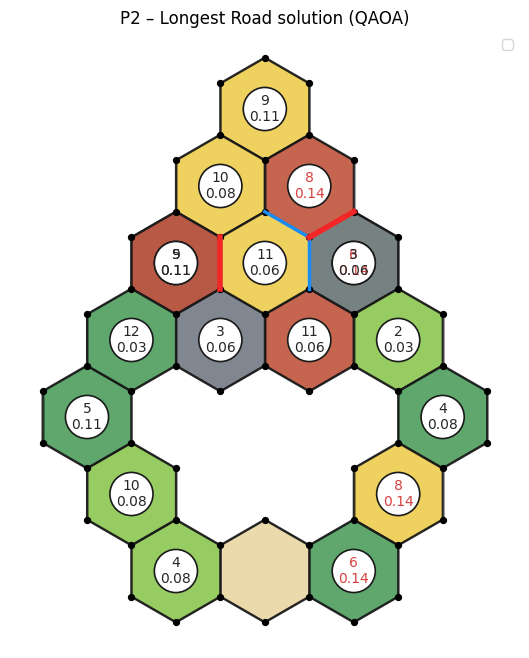

In [8]:
# --- Visualize Solution ---
chosen_edges = [Q_model.id_of[i] for i, b in enumerate(bitstring[::-1]) if b == '1']
cprint(f"Chosen edges: {chosen_edges}", Colors.YELLOW)

fig, ax = plot_board(board)
highlight_edges(board, selected_edges, ax=ax, color=(0.10, 0.55, 0.95), width=2.5, label='Candidates')
highlight_edges(board, chosen_edges, ax=ax, color=(0.95, 0.15, 0.15), width=4.0, label='Chosen')
ax.set_title(f"P2 – Longest Road solution ({METHOD.upper()})")
plt.show()

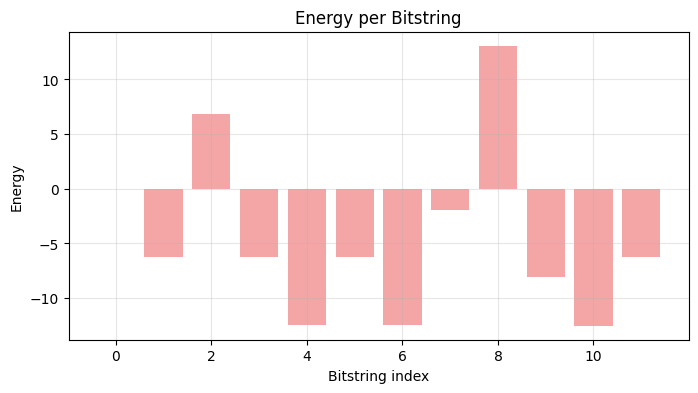

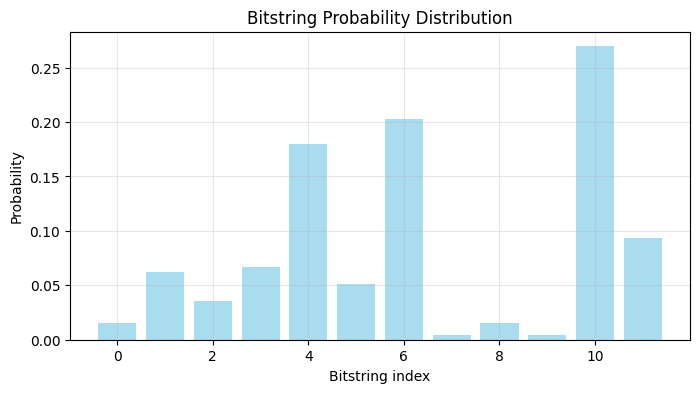

In [9]:
# --- Energy / Probability plots ---
if METHOD.lower() == 'qaoa':
    plot_energy_landscape(result['bitstrings'], Q)
else:
    plot_vqe_convergence(result['energy_history'])
    plot_vqe_probabilities(result['probabilities'], Q)

In [10]:
# --- Save artefacts ---
out = Path('data'); out.mkdir(exist_ok=True)
np.save(out / 'p2_Q.npy', Q)
with open(out / 'p2_best.txt', 'w') as f:
    f.write(f'METHOD={METHOD}\nbitstring={bitstring}\nenergy={energy}\n')
cprint(f'Saved results to {out}/p2_Q.npy and p2_best.txt', Colors.GREEN)

Saved results to data/p2_Q.npy and p2_best.txt
